In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import gym
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
env=gym.make('Blackjack-v0')

In [4]:
for  i in range(3):
    state=env.reset()
    while True:
        print(state)
        action=env.action_space.sample()
        state,reward,done,info=env.step(action)
        if done:
            print("the reward obtained is ",reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(16, 6, False)
the reward obtained is  -1.0
You lost :(

(20, 4, False)
the reward obtained is  -1
You lost :(

(10, 5, False)
the reward obtained is  -1.0
You lost :(



In [5]:
def get_probs(Q_state,epsilon,nA):
    """
    Q_state:-It is a subset of Q contains action values corresponding to one state
    epsilon:p(equiprobable random policy)  &&  1 - epsilon : p(greedy policy) 
    nA:-number of actions
    """
    probs=np.ones(nA)*epsilon/nA
    greedy_action=np.argmax(Q_state)
    probs[greedy_action]=1-epsilon+epsilon/nA
    
    return probs


In [6]:
def get_episodes(env,Q,epsilon,nA):
    episode=[]
    state=env.reset()
    while True:
        probs=get_probs(Q[state],epsilon,nA)
        if state in Q:
            action=np.random.choice(np.arange(2),p=probs)
        else:
            action=env.action_space.sample()
        next_state,reward,done,info=env.step(action)
        episode.append((state,action,reward))
        state=next_state
        if done:
            break
    return episode

        
        

In [7]:
def monte_carlo_evaluation(env,Q,episode,alpha,gamma):
    state, action, reward = zip(*episode)
    discounts = np.array([gamma**t for t in range(len(reward)+1)])
    for t, state in enumerate(state):
        old_state=Q[state][action[t]]
        G_t = sum(discounts[:-(t+1)] * reward[t:]) 
        Q[state][action[t]]=old_state+alpha*(G_t-old_state)
                
    return Q 
    
    
    

In [8]:
def monte_carlo_control(env,alpha,num_episodes,epsilon_start=1.0,epsilon_decay=0.99999,epsilon_min=0.05,gamma=1.0):
    nA=env.action_space.n
    Q=defaultdict(lambda:np.zeros(nA))
    epsilon=epsilon_start
    for i in range(1,num_episodes+1):
        epsilon=max(epsilon*epsilon_decay,epsilon_min)
        episode=get_episodes(env,Q,epsilon,nA)
        Q=monte_carlo_evaluation(env,Q,episode,alpha,gamma)
        if i % 1000 == 0:
            print('\rEpisode {}/{}.'.format(i, num_episodes), end = "")
            sys.stdout.flush()
        policy = dict((k,np.argmax(v)) for k, v in Q.items())        
    return policy,Q
            
        
    

In [9]:
"""
Plotting functions  are used from udacity Reinforcement learning

"""

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


In [12]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [13]:
num_iterations=500000
alpha=0.02
(policy,Q)=monte_carlo_control(env,alpha,num_iterations)
V = dict((k,np.max(v)) for k, v in Q.items())


Episode 500000/500000.

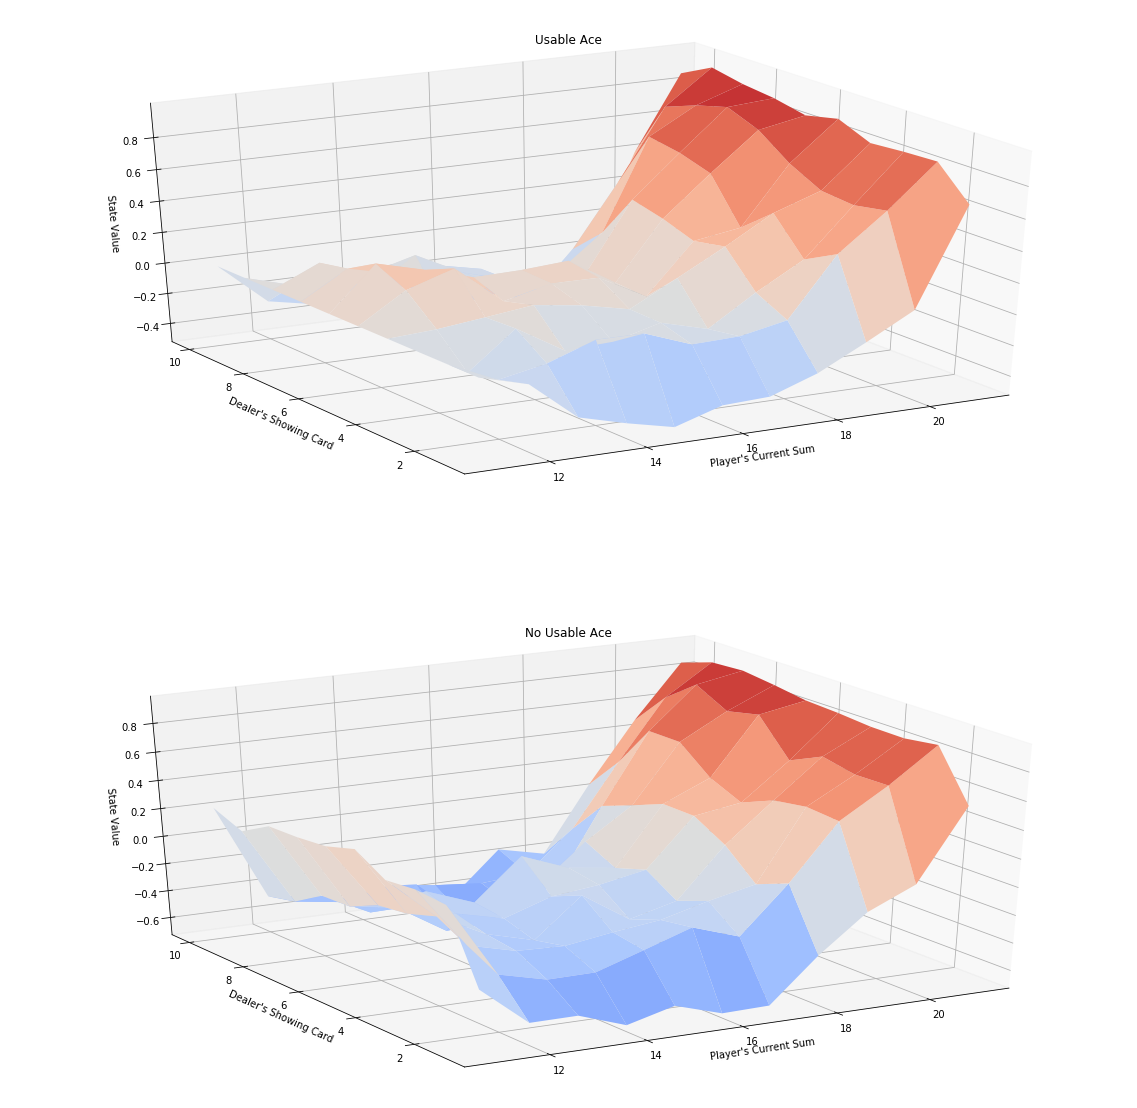

In [14]:
plot_blackjack_values(V)



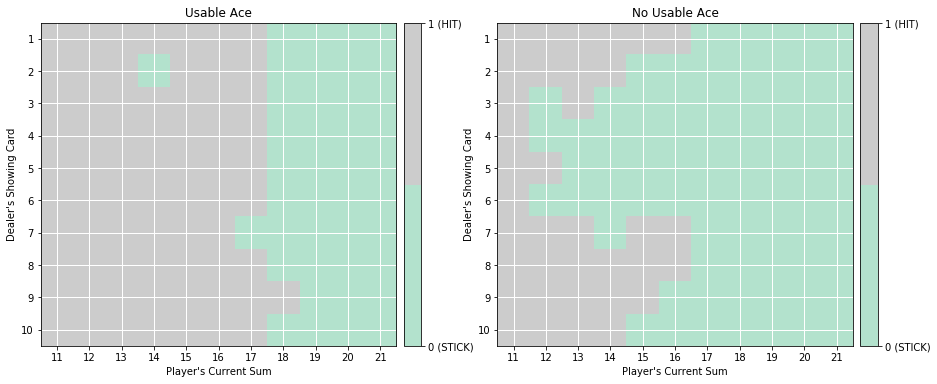

In [15]:
plot_policy(policy)